# This notebook uses pytorch lightning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm
import pytorch_lightning as pl
import sys

import math
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("smartmeters.ipynb")

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
from src.models.model import LatentModel
from src.data.smart_meter import collate_fns, SmartMeterDataSet, get_smartmeter_df
from src.plot import plot_from_loader
from src.models.lightning_anp import LatentModelPL

In [5]:
# Params
device='cuda'
use_logy=False

# Load kaggle smart meter data

In [6]:
df_train, df_test = get_smartmeter_df()

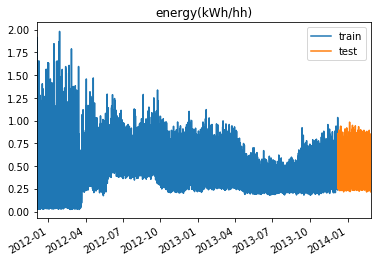

In [7]:
# Show split
df_train['energy(kWh/hh)'].plot(label='train')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Plot helpers

# Model

In [8]:
# Set our params here, in a way compatible with cli
argv = f"""
--x_dim {df_train.shape[-1]-1} \
--y_dim 1 \
--max_nb_epochs 40 \
--vis_i 670 \
--gpus 0 \
""".replace('\n','').strip().split(' ')

In [9]:
from pytorch_lightning import Trainer
from argparse import ArgumentParser  

parser = ArgumentParser(add_help=False)
parser.add_argument('--gpus', type=str, default=None)
parser.add_argument('--nodes', type=int, default=1)

# give the module a chance to add own params
parser = LatentModelPL.add_model_specific_args(parser)

# parse params
hparams = parser.parse_args(argv)
print(hparams)

----------------------------------------------------------------------------------------------------
Hyperparameters:
gpus                : 0
nodes               : 1
learning_rate       : 0.0001
batch_size          : 16
x_dim               : 16
y_dim               : 1
vis_i               : 670
hidden_dim          : 128
latent_dim          : 128
num_heads           : 8
n_latent_encoder_layers: 4
n_det_encoder_layers: 4
n_decoder_layers    : 2
dropout             : 0
attention_dropout   : 0
min_std             : 0.01
latent_enc_self_attn_type: multihead
det_enc_self_attn_type: multihead
det_enc_cross_attn_type: multihead
use_lvar            : False
use_deterministic_path: True
grad_clip           : 0
num_context         : 48
num_extra_target    : 24
max_nb_epochs       : 40
num_workers         : 4
hpc_exp_number      : None
trials              : <bound method HyperOptArgumentParser.opt_trials of HyperOptArgumentParser(prog='ipykernel_launcher.py', usage=None, description=None, formatter_

# Run

In [ ]:
# import os
# from test_tube import Experiment

# model = LatentModelPL(hparams)


# # most basic trainer, uses good defaults
# trainer = Trainer(
#     max_epochs=hparams.max_nb_epochs,
#     gpus=hparams.gpus,
#     nb_gpu_nodes=hparams.nodes,
#     gradient_clip_val=hparams.grad_clip,
#     track_grad_norm=1,
#     show_progress_bar=True
# )
# # model.trainer = trainer
# trainer.fit(model)

# Hyperparam search

In [90]:
from test_tube import HyperOptArgumentParser
from run_lightning_anp import add_default_args
import os
import random


def main(hparams):
    if hparams.seed is not None:
        random.seed(hparams.seed)
        torch.manual_seed(hparams.seed)
        torch.backends.cudnn.deterministic = True
    print(hparams)
    # build model
    model = LatentModelPL(hparams)
    # configure trainer
    trainer = Trainer(
#         default_save_path=hparams.save_path,
        max_epochs=hparams.max_nb_epochs,
        gpus=hparams.gpus,
        gradient_clip_val=hparams.grad_clip,
        track_grad_norm=1,
    )
    # train model
    if hparams.evaluate:
        trainer.run_evaluation()
    else:
        trainer.fit(model)
        
# use default args given by lightning
# root_dir = os.path.split(os.path.dirname(sys.modules['__main__'].__file__))[0]
root_dir = os.path.split(os.getcwd())[0]

parent = HyperOptArgumentParser(strategy='random_search', add_help=False)

parent = add_default_args(parent)

# allow model to overwrite or extend args
parser = LatentModelPL.add_model_specific_args(parent)



In [103]:
hyperparams.__dict__

{'gpus': -1,
 'nodes': 1,
 'hpc_exp_number': 1,
 'seed': 42,
 'evaluate': False,
 'learning_rate': 0.0001,
 'batch_size': 16,
 'x_dim': 16,
 'y_dim': 1,
 'vis_i': 670,
 'hidden_dim': 128,
 'latent_dim': 128,
 'num_heads': 8,
 'n_latent_encoder_layers': 4,
 'n_det_encoder_layers': 4,
 'n_decoder_layers': 2,
 'dropout': 0,
 'attention_dropout': 0,
 'min_std': 0.01,
 'latent_enc_self_attn_type': 'multihead',
 'det_enc_self_attn_type': 'multihead',
 'det_enc_cross_attn_type': 'multihead',
 'use_lvar': False,
 'use_deterministic_path': True,
 'grad_clip': 0,
 'num_context': 48,
 'num_extra_target': 24,
 'max_nb_epochs': 20,
 'num_workers': 4,
 'trials': <bound method HyperOptArgumentParser.opt_trials of HyperOptArgumentParser(prog='ipykernel_launcher.py', usage=None, description=None, formatter_class=<class 'argparse.HelpFormatter'>, conflict_handler='error', add_help=True)>,
 'optimize_parallel': <bound method HyperOptArgumentParser.optimize_parallel of HyperOptArgumentParser(prog='ipykern

In [91]:
hyperparams = parser.parse_args([])

# train model
# main(hyperparams)

In [109]:
import copy
hparams = copy.deepcopy(hyperparams)
for k in dir(hparams):
    v = getattr(hparams, k)
    if not isinstance(v, (int, float, str, bool, torch.Tensor)):
        setattr(hparams, k, None)
hparams

TypeError: __class__ must be set to a class, not 'NoneType' object

In [94]:
72-48

24

In [96]:
# Run some trials on a single cpu. You can view them in tensorboard, and see the hyper params
trials = hyperparams.generate_trials(8)
for trial in trials:
    main(trial)

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0


----------------------------------------------------------------------------------------------------
Hyperparameters:
learning_rate       : 0.0037216107638185568
hidden_dim          : 128
latent_dim          : 512
n_latent_encoder_layers: 8
n_det_encoder_layers: 1
n_decoder_layers    : 8
dropout             : 0.3553951704743503
attention_dropout   : 0.10436943022123696
latent_enc_self_attn_type: laplace
det_enc_self_attn_type: multihead
det_enc_cross_attn_type: laplace
use_lvar            : True
use_deterministic_path: True
gpus                : -1
nodes               : 1
hpc_exp_number      : 1
seed                : 42
evaluate            : False
batch_size          : 16
x_dim               : 16
y_dim               : 1
vis_i               : 670
num_heads           : 8
min_std             : 0.01
grad_clip           : 0
num_context         : 48
num_extra_target    : 24
max_nb_epochs       : 20
num_workers         : 4



INFO:root:
                                          Name           Type Params
0                                        model    LatentModel    5 M
1                        model._latent_encoder  LatentEncoder  285 K
2           model._latent_encoder._input_layer  NPBlockRelu2d    2 K
3    model._latent_encoder._input_layer.linear         Linear    2 K
4       model._latent_encoder._input_layer.act           ReLU    0  
..                                         ...            ...    ...
118              model._decoder._decoder.7.act           ReLU    0  
119          model._decoder._decoder.7.dropout      Dropout2d    0  
120             model._decoder._decoder.7.norm    BatchNorm2d    1 K
121                       model._decoder._mean         Linear  769  
122                        model._decoder._std         Linear  769  

[123 rows x 3 columns]


RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 2. Got 72 and 48 in dimension 1 at /pytorch/aten/src/THC/generic/THCTensorMath.cu:71

In [ ]:
%debug